Final score (RMSE): 0.6761101500006892


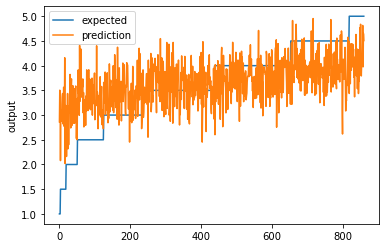

,business_name,true_stars,predicted_stars
0,Oskar Blues Taproom,4.5,4.371078
1,Flying Elephants at PDX,3.0,3.367530
2,The Reclaimory,4.0,3.833482
3,Great Clips,4.0,3.820260
4,Crossfit Terminus,4.5,3.709927


In [18]:
from importlib.machinery import SourceFileLoader
helpers = SourceFileLoader("helpers", "./helpers.py").load_module()
import os
import numpy as np
import pandas as pd
from sklearn import metrics
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

business_data_frame = pd.read_json('./dataset/business.json', lines=True)

# Removing all businesses with less then 20 reviews because of project requirements
filtered_business_data_frame = business_data_frame[business_data_frame['review_count'] >= 20]

review_data_frame = pd.read_json('./dataset/reviews.json', lines=True, nrows=10000)

# having all reviews joined together with the business id so all the text can be in one row. 
# this will help when we vectorize the text
aggregated_business_reviews = review_data_frame.groupby('business_id')['text'].sum()

aggregated_business_review_data_frame = pd.DataFrame({'business_id': aggregated_business_reviews.index, 'all_reviews': aggregated_business_reviews.values})

# join the tables so that we can have the business and reviews in the same table. 
# this will help us later when we want to refer to business attributes
joined_business_review_data_frame = pd.merge(business_data_frame, aggregated_business_review_data_frame, on='business_id')

# Compute a weight to each word which signifies the importance of the word
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features = 1000, min_df=1)

reviewMatrix = vectorizer.fit_transform(joined_business_review_data_frame['all_reviews'])

# Convert both the reviews and the stars to numpy arrays so the data matches when we go to test
numpyReviews = reviewMatrix.toarray()
numpyStars = joined_business_review_data_frame['stars'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(numpyReviews, numpyStars, test_size=0.20, random_state=42)

model = Sequential()

# having any more layers did not help
# 5 for this layer seem to be the sweet spot. any lower increased RMSE. any Higher had the same value until I went past 10
model.add(Dense(5, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(1))


# sgd ended up performing the best. I found that lowering the learning_rate had little to no effect. It just increased
# the amount of time to fit
sgd = optimizers.SGD(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=sgd)

# stops when data is flattening out
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=0,epochs=1000)

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

df_business_name = pd.DataFrame(joined_business_review_data_frame['name'].to_numpy(), columns=['business_name'])
df_y = pd.DataFrame(y_test, columns=['true_stars'])
df_pred = pd.DataFrame(pred, columns=['predicted_stars'])
result = pd.concat([df_business_name, df_y, df_pred],axis=1)

helpers.chart_regression(pred.flatten(),y_test, sort=True)

result[0:5]



